# Instagram: Analysis of account hashtags, likes, and comments over time

<br>

## Goal:

Instagram business accounts have the functionality to look at a users post statistics -- what time of day do they get the most likes? What hashtags give them the most likes? Which hashtags are you using the most? But if you're managing an instagram account, you might be curious about the statistics for other SIMILAR businesses. For example, if you're a boutique shoe store, you might want to know what hashtags other shoe stores are using and which of those hashtags are associated with the most likes. What time of day are other shoe stores posting and what time of day or year gets these posts the most likes? If there is a particularly successful instagram account that you would like to emulate, being able to view that account's statistics could help you boost engagement on your own instagram account and ultimately help your business.

The goal of this project is to create a web scraping bot with Selenium that will log in to an instagram account, then navigate to an account that the user specifies and scrapes the post information from said account. The bot will scrape information on date and time of posting, number of likes/views, the original post comment, and the original post hashtags.

In the code below we perform an example using the Instagram account of the Los Angeles based dog adoption agency Tobies Small Dog Rescue (because, come on, who doesn't like cute puppies?). We will scrape the infromation from all the posts on the 'tobiessmalldogrescue' instagram account and analyze the most used hashtags, which hashtags are associated with the most likes, and which dates and times are associted with the most likes. 

## Steps  

<br>

#### Load Libraries  

<br>

#### Create a class that controls a Chrome driver to:

1) start driver

2) login to personal account

3) scroll down instagram page of an account of your choice collecting the post URLs

4) navigate to each post URL and scrape the likes, date, time, and comment from each post
 
5) extract hashtags from each comment and turn into long form data frame (one row per hashtag)

<br>

#### Use the hashtag and post information to ask: 

1) How many times is each hashtag used?
 
2) Which hashtags had the most likes?

3) What is the relationship between time of posting and number of likes?

4) What is the relationship between average number of likes and the month?

<br>

Essentially this could be a way to look at the competition for people in your field - what hashtags are they using, what is successful, when is it successful for them, etc

## Load the Libraries

In [32]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import time
import pandas as pd
import numpy as np
import re
from itertools import compress
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from selenium.common.exceptions import NoSuchElementException
from datetime import datetime
%matplotlib inline

## Create the InstaBot 

In [82]:
class InstaBot:
    
    """This is a Chrome driver bot that will scrape information from each instagram post from
    a specified instagram account"""
    
    def startup(self, driver_location):
        """Starts up the Chrome driver and makes it a full size window"""
        self.driver = webdriver.Chrome(driver_location)
        self.driver.maximize_window()
    
    def shut_it_down(self):
        self.driver.quit()
    
    def login_to_profile(self, username, password):
        """Navigate to instagram and login to your instagram profile"""
        url = 'https://www.instagram.com/'
        self.driver.get(url)
        ## pause
        time.sleep(5)
        ## enters username
        self.driver.find_element_by_xpath("//input[@name='username']").send_keys(username)
        ## enters password
        self.driver.find_element_by_xpath("//input[@name='password']").send_keys(password)
        ## pause
        time.sleep(5)
        ## click login
        self.driver.find_element_by_xpath("//button[contains(.,'Log In')]").click()
        time.sleep(10)
        ## not now! (Save login info)
        self.driver.find_element_by_class_name('cmbtv').click()
        time.sleep(10)
        ## not now! again! (Receive notifications)
        self.driver.find_element_by_class_name('HoLwm').click()
        ## open your profile
        self.driver.get(url + username + '/')
    
    def recent_posts(self, account): 
        """scrolls through the instagram account and scrapes the url for each post """
        url = 'https://www.instagram.com/'
        ## account of interest url
        url = "%s%s/" % (url, account)
        self.driver.get(url)
        ## get total number of posts from account front page text
        num_posts = self.driver.find_element_by_class_name('g47SY').text
        num_posts = int(num_posts.replace(',', ''))
        post = 'https://www.instagram.com/p/'
        ## empty object to save output of the while loop 
        post_links = []
        ## runs until your post_links is as long as your designate
        while len(post_links) < num_posts:
        #while len(post_links) < 5: ## if you want to test it without taking ages
        ## extract the links
            links = [a.get_attribute('href') for a in self.driver.find_elements_by_tag_name('a')]
        ## if the link is a post link and hasn't already
        ## been added to the list, add the url to the post_links obeject
            for link in links:
                if post in link and link not in post_links:
                    post_links.append(link)
        ## browser scrolls down to the bottom of the page (window.scrollTo(0) where 0 is the 
        ## bottom of the page
            scroll_down = "window.scrollTo(0, document.body.scrollHeight);"
            self.driver.execute_script(scroll_down)
        ## time sleep tells the browser to wait 10 seconds after scrolling down before
        ## trying to access the new links that have loaded - this gives time for the 
        ## links to load and makes the bot scrolling look more "natural"
            time.sleep(10)
        else:
            return post_links[:num_posts]
    
    def get_the_details(self, url, account):
        """Navigates to a post url and scrapes all of the information from the post including
        the comment, the number of likes or views, the date and time, the link,
        and the username"""
        self.driver.get(url)
        time.sleep(10)
        
        try:
            ## try and run if the post link works
            self.driver.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div[1]/article/header/div[2]/div[1]/div[1]/div/a')
            
            ## Start with scraping 'likes' and 'views' information
            
            try:
                ## scrape number of likes by class name
                likes = self.driver.find_element_by_class_name('Nm9Fw').text
            except:
                ## scrape number of views by class name (if video post)
                likes = self.driver.find_element_by_class_name('vcOH2').text
            ## for posts that were liked by a follower in common, the 'liked' value will start with 
            ## 'Liked by' so you can extract the number of likes and then add one for the mutual 
            ## follower
            if 'Liked by' in likes:
                temp = likes.split()[4]
                if ',' in temp:
                    like_count = int(temp.replace(',', '')) + 1
                else:
                    like_count = int(temp)
            else: 
                temp = likes.split()
                like_count = int(temp[-2].replace(',', ''))
            
            ## Now scrape date and time information of the post
            
            ## xpath location for the date and time
            xpath_time = '//*[@id="react-root"]/section/main/div/div/article/div[2]/div[2]/a/time'
            ## scrape the date and time of the post
            date_time = self.driver.find_element_by_xpath(xpath_time).get_attribute('datetime')
            
            ## make the datetime a datetime object and extract the useful information
            z = list(date_time)[-1]
            dt_object = datetime.strptime(date_time, "%Y-%m-%dT%H:%M:%S.%f"+z)
            post_date = dt_object.date()
            post_time = dt_object.time()
            post_month = post_date.month
            post_year = post_date.year
            post_hour = post_time.hour
            
            ## Finally scrape the whole comment if there is an original poster comment
            try:
                comment = self.driver.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div[1]/article/div[2]/div[1]/ul/div/li/div/div/div[2]/span').text
            ## if there is no comment, make it blank
            except:
                comment = ''
            
            ## Now put all information together into a dictionary for that post
            post_details = {'username': account, 'likes': like_count,'date': post_date, 'time': post_time,
                            'month': post_month, 'year': post_year, 'hour': post_hour, 'comment': comment}
            #post_details = {'username': account, 'likes': like_count,'date': datetime, 'comment': comment}
            
            ## pause
            time.sleep(5)
            
        except NoSuchElementException:
            ## if the post doesn't work for some reason, fill all values with 'None' or equivalent
            post_details = None
            
            ## pause
            time.sleep(5)
        return post_details
    
    def drop_None_vals(self, post_details):
        """Drops the elements of the list that equal 'None' in the event that the post failed to 
        load"""
        post_details = [x for x in post_details if x] 
        return post_details

    def hashtag_info(self, one_post):
        """Extracts the hashtags from the post comment"""
        ## make the list a dataframe
        x = pd.DataFrame([one_post])
        ## extract the actual hashtags
        hashtags = list(re.findall('#(\w+)', one_post['comment']))
        ## if hashtags in comment, assemble them all into a dataframe with otherwise repeated
        ## row values
        if len(hashtags) > 0:
            hashtags = hashtags
            x = pd.concat([x]*len(hashtags))
        else: 
            hashtags = 'None'
        x['hashtag'] = hashtags
        return(x)
    
    def concat_hashtag_df(self, hashtag_details):
        """Concatenates all the post information dataframes together into one"""
        hashtag_details = pd.concat(hashtag_details)
        hashtag_details = hashtag_details.reset_index()
        return(hashtag_details)


## Run the bot

Now that we have created the bot we can run it and execute the scrape -- this included information on my personal Instagrame account (for the login) so I am not including it here, but I load the data below and continue with the analysis. 

In [98]:
hashtag_df = pd.read_pickle('hashtag_df_v1.pkl')
hashtag_df = hashtag_df.drop(['index'], axis = 1)

In [99]:
hashtag_df.head()

,username,link,likes/views,datetime,comment,hashtag,likes,date,time,month,year,hour
0,tobiessmalldogrescue,/CB393X0pdzx/,237 likes,2020-06-25T22:15:41.000Z,‼️‼️Scroll right for the CUTENESS OF MACK‼️‼️ ...,bassethound,237,2020-06-25,22:15:41,6,2020,22
1,tobiessmalldogrescue,/CB393X0pdzx/,237 likes,2020-06-25T22:15:41.000Z,‼️‼️Scroll right for the CUTENESS OF MACK‼️‼️ ...,bassetthoundmix,237,2020-06-25,22:15:41,6,2020,22
2,tobiessmalldogrescue,/CB393X0pdzx/,237 likes,2020-06-25T22:15:41.000Z,‼️‼️Scroll right for the CUTENESS OF MACK‼️‼️ ...,adoptdontshop,237,2020-06-25,22:15:41,6,2020,22
3,tobiessmalldogrescue,/CB393X0pdzx/,237 likes,2020-06-25T22:15:41.000Z,‼️‼️Scroll right for the CUTENESS OF MACK‼️‼️ ...,fosteringsaveslives,237,2020-06-25,22:15:41,6,2020,22
4,tobiessmalldogrescue,/CB393X0pdzx/,237 likes,2020-06-25T22:15:41.000Z,‼️‼️Scroll right for the CUTENESS OF MACK‼️‼️ ...,rescuedogsofinstagram,237,2020-06-25,22:15:41,6,2020,22


In [72]:
## create a checkpoint
hashtag_df_check = hashtag_df

## Hashtag Analysis 
<br>

### How many times is each hashtag used?

The top twenty hashtags

In [100]:
top_hashtags = pd.DataFrame(hashtag_df.hashtag.value_counts().iloc[:20])

In [101]:
top_hashtags

,hashtag
adoptdontshop,1144
fosteringsaveslives,740
donate,519
rescuedog,519
foster,499
shelterdog,461
chihuahuasofinstagram,460
chihuahua,440
chihuahuapuppy,413
puppies,392


Bar plot for the top twenty hashtags

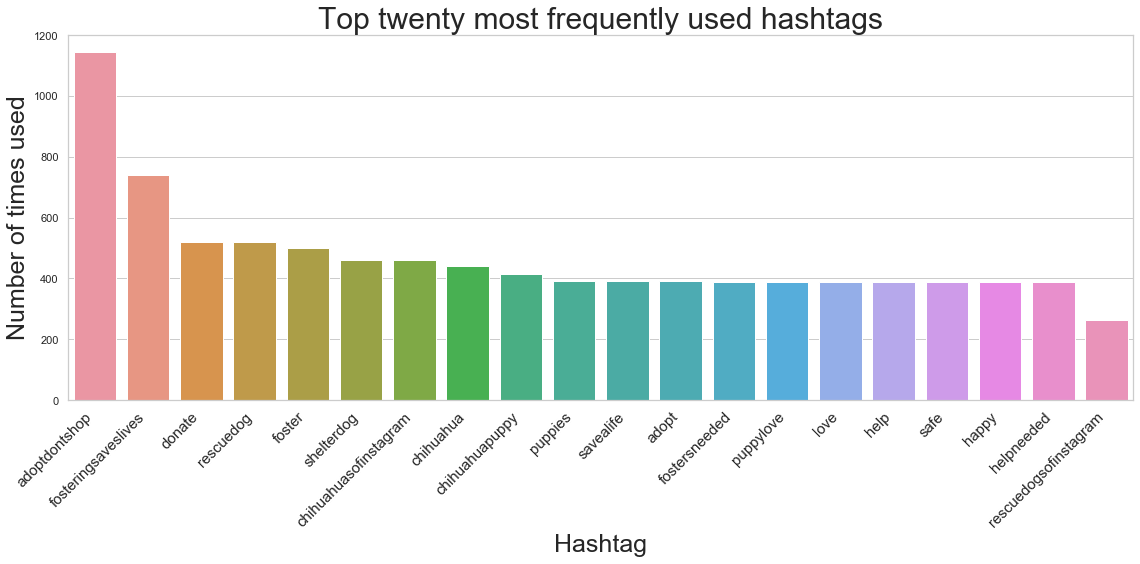

In [102]:
plt.figure(figsize = (16,8))
sns.countplot(x = "hashtag", data = hashtag_df, 
              order = hashtag_df.hashtag.value_counts().iloc[:20].index)
plt.title("Top twenty most frequently used hashtags", fontsize = 30)
plt.xlabel("Hashtag", fontsize = 25)
plt.ylabel("Number of times used", fontsize = 25)
plt.xticks(rotation=45, fontsize = 15, ha = "right")
plt.tight_layout()
plt.show()

The most used hashtag by this account is "adoptdontshop" followed by "fosteringsaveslives". The rest of the hashtags have surprisingly equal usage until you get to "rescuedogsofinstagram". Among the most used hashtags are three that relate specifically to chihuahuas, which indcates that this dog rescue business gets a lot of chihuahuas! This makes sense since chihuahuas are small dogs (and this account is specifically a small dog rescue), and chihuahuas are [among the most common dog breeds in shelters](https://www.petinsurancereview.com/blog/dog-breeds-in-shelters). 

### Which hashtags had the most likes?

In [103]:
## total number of likes per hashtag
## not that useful since hashtags are used with different frequency
hashtag_df.groupby(["hashtag"]).sum().sort_values(by = 'likes', ascending = False)

,likes
hashtag,
adoptdontshop,421201
fosteringsaveslives,278975
rescuedog,205507
shelterdog,183406
donate,155453
...,...
lostyorkie,67
dogtricks,57
dogs,57


In [104]:
## mean bumber of likes per hashtag
hashtag_df.groupby(["hashtag"]).mean().sort_values(by = 'likes', ascending = False)

,likes
hashtag,
longhairdachshundmix,1532.0
pugglemom,1474.0
poodlepuppies,1440.0
pekingnesemix,1219.0
teacupchihuahua,1207.6
...,...
lostyorkie,67.0
shelterinplace,57.0
socialdistancing,57.0


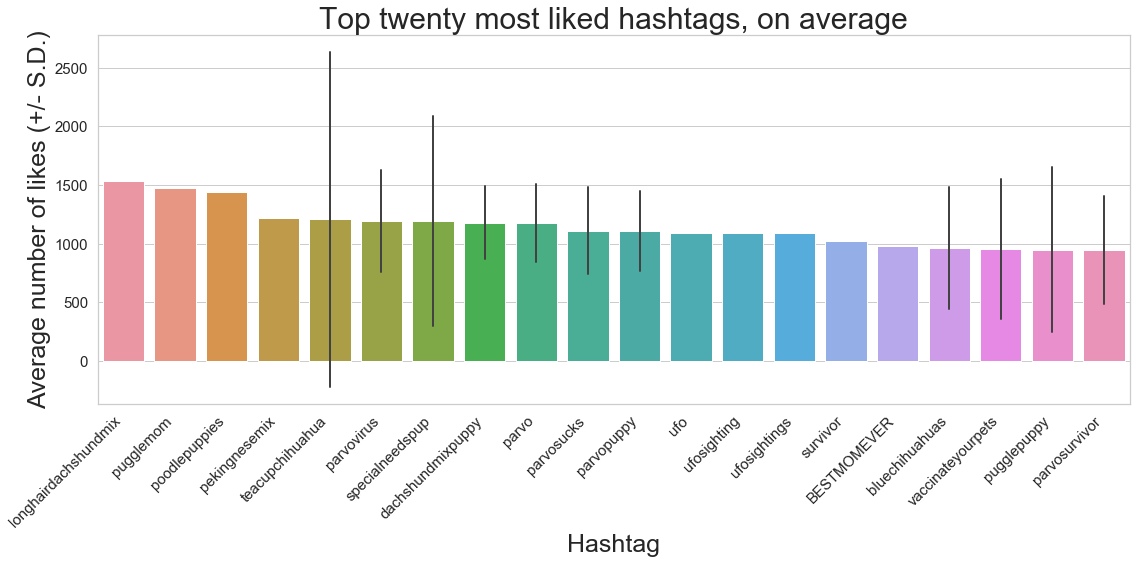

In [105]:
# create plot
plt.figure(figsize = (16,8))
sns.set(style = "whitegrid")
sns.barplot(x = "hashtag", y = "likes", data = hashtag_df,
           errwidth = 2, ci = 'sd',
           order = hashtag_df.groupby(["hashtag"]).mean().sort_values(by = 'likes', ascending = False).iloc[:20].index)
plt.title("Top twenty most liked hashtags, on average", fontsize = 30)
plt.xlabel("Hashtag", fontsize = 25)
plt.ylabel("Average number of likes (+/- S.D.)", fontsize = 25)
plt.xticks(rotation=45, fontsize = 15, ha = "right")
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

The most liked hashtag in the history of this account is "longhairdachshundmix" which is interesting because it was only ever used once (indicated by the lack of standard deviation around average number of likes). The top five hashtags are all related to specific dog breeds, which indicates that followers are very interested in long hair daschunds, puggles, poodles, pekingese mixes, and teacup chihuahuas. Also in the top ten most liked hashtags are several references parvovirus, a [very serious contagious virus](https://www.avma.org/resources-tools/pet-owners/petcare/canine-parvovirus) that affects dogs, especially puppies that are not able to get vaccinated. The popularity of this hashtag among followers indicates that they are interested in learning more about parvo and concerned with parvo transmission in adoptable dogs.

#### What is the relationship between time of posting and number of likes?

In [106]:
dates_df = hashtag_df.drop_duplicates('time')

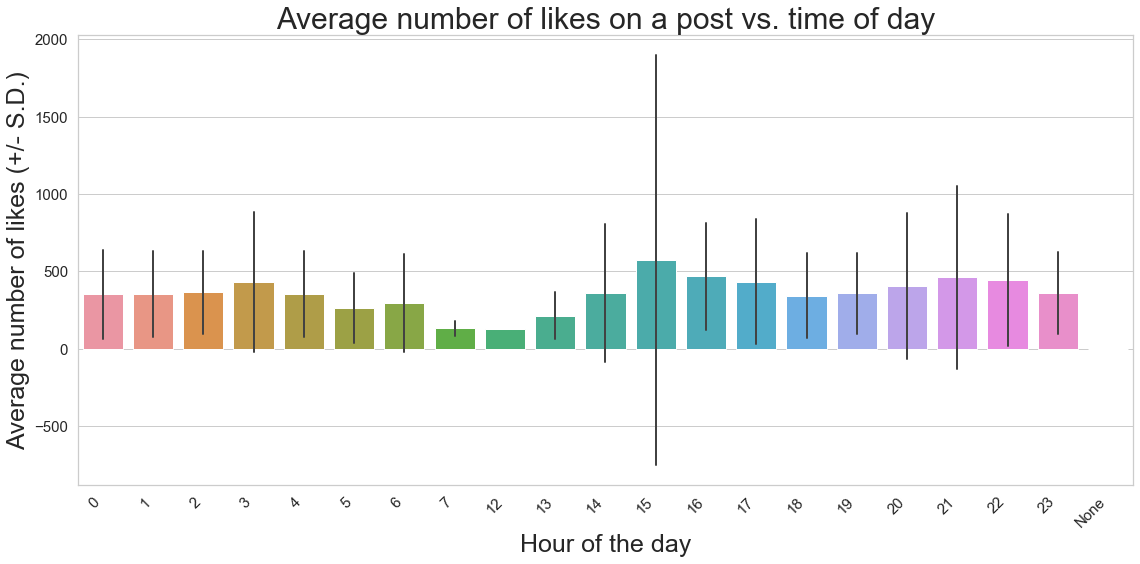

In [107]:
plt.figure(figsize = (16,8))
sns.set(style = "whitegrid")
sns.barplot(x = "hour", y = "likes", data = dates_df, 
           errwidth = 2, ci = "sd",
           order = dates_df.groupby(["hour"]).mean()['likes'].index)
plt.title("Average number of likes on a post vs. time of day", fontsize = 30)
plt.xlabel("Hour of the day", fontsize = 25)
plt.ylabel("Average number of likes (+/- S.D.)", fontsize = 25)
plt.xticks(rotation=45, fontsize = 15, ha = "right")
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

Based on the average number of likes for each hour of the day, the times to post that are most likely to get the greatest number of likes is the mid afternon and the late evening (9pm west coast time). The worst time to post to get a high number of likes is between 7am and 12pm PT (in fact, the brand doesn't even post between 8 and 11 am perhaps because they are already aware of this lull in engagement between those hours). 

#### What is the relationship between average number of likes and the month?

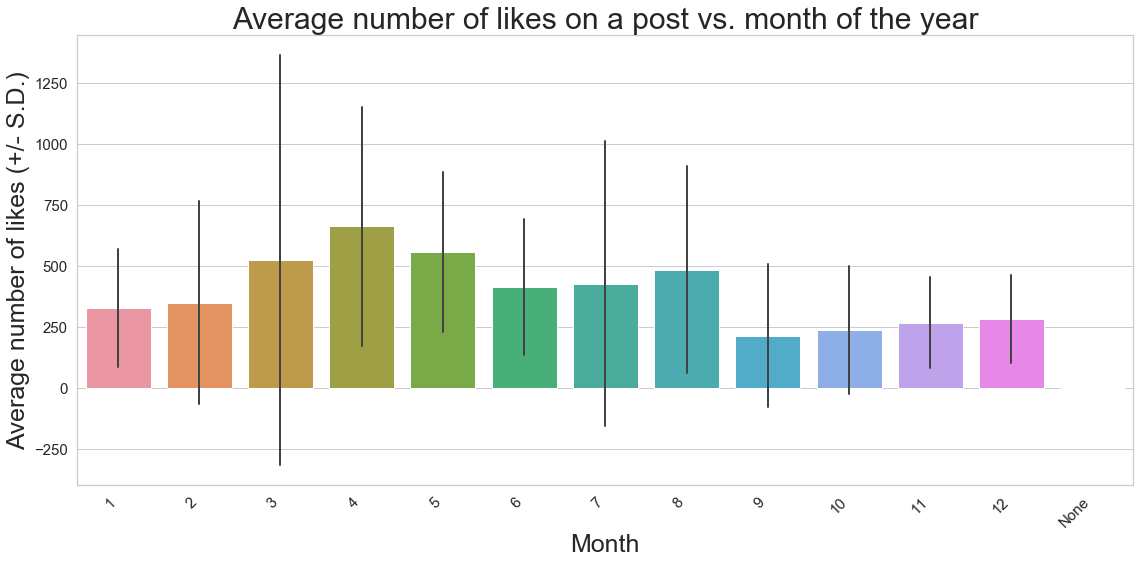

In [108]:
plt.figure(figsize = (16,8))
sns.set(style = "whitegrid")
sns.barplot(x = "month", y = "likes", data = dates_df, 
           errwidth = 2, ci = "sd",
           order = dates_df.groupby(["month"]).mean()['likes'].index)
plt.title("Average number of likes on a post vs. month of the year", fontsize = 30)
plt.xlabel("Month", fontsize = 25)
plt.ylabel("Average number of likes (+/- S.D.)", fontsize = 25)
plt.xticks(rotation=45, fontsize = 15, ha = "right")
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

Interestingly, April is the month with the greatest average number of likes on a post. If you had asked me I would have guess that for a dog adoption agency, the greatest user engagement would have been around the holidays or in the summer, but here we can see it is the spring. All of these factors (hour, month, hashtag) of course all interact to determine how much user engagement there is with a post, which can be explored using machine learning algorithms in a later post! 

### Conclusions

<br>

This tool could be very useful for any business (or even personal instagram) account that is looking to boost their engagement by taking tips from other, potentially more successful users. You could run this for a single account you are specifically intereted in, or you could run it for multiple accounts to give yourself a lot of ideas. As a business, you could use this tool to get ideas for when to post to your instagram and what hashtags you can use to boost engagement. Hopefully the increased engagement would translate into increased revenue for your business! 

<br>

#### Future directions

<br>

There is obviously a lot you can do with instagram data! One thing that might be valuable to business owners is understanding their social network in relation to the social networks of other similar businesses. This type of social network analysis could provide the business owner with highly personalized ideas for potential followers and hashtag use. Another fruitful avenue of research would include an NLP analysis of the post comment content to deepen the understanding of the content of a particular account to further provide post content and hashtag suggestions. Furthermore, NLP analysis could be performed on the instagram account post's comments (not just the original post comment) to analyze the sentiments of the engagement with the company and get a better idea of what interests (or doesn't interest!) the users that are engaging with a particular instagram account. 
